# Decision Trees and Random Forests

Random forests are an example of an __ensemble method__. They aggregate the results of multiple simpler estimators. The sum can be greater than the parts - a majority vote among the estimators be better than any individual estimator.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

### Decision Tree Basics

Random forests are built on decision trees. Decision trees are classification tools: you ask a series of questions designed to zero in on the classification. To build an animal classification decision tree you might do this:

![](05.08-decision-tree.png)

__Binary splitting__ makes this extremely efficient. Each question in a well-constructed tree will cut the number of options by approximately half, which quickly narrows the options even among a large number of classes.

Decision tree questions resemble axis-aligned data splits. Each node splits the data into two groups using a cutoff value within one of the features.

### Creating a decision tree

Consider the following two-dimensional data, which has one of four class labels:

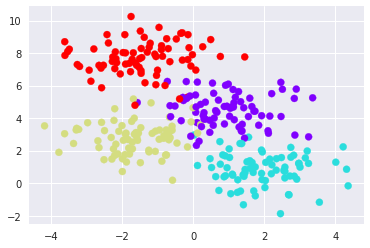

In [6]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

Decision trees iteratively split the data along an axis according to a criterion. Labels are assigned to the new region according to a majority vote of points within it. Here's the visual of the first four levels.

Note: after the first split, every point in the upper branch remains unchanged. (There is no need to further subdivide this branch.) Except for nodes that contain all of one color, at each level *every* region is again split along one of the two features.

![](05.08-decision-tree-levels.png)

Scikit uses the ``DecisionTreeClassifier`` estimator.

In [7]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

In [8]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap, clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, # clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

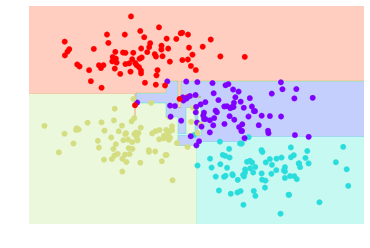

In [9]:
visualize_classifier(DecisionTreeClassifier(), X, y)

- If you're running this notebook live, you can use the helpers script included in [The Online Appendix](06.00-Figure-Code.ipynb#Helper-Code) to bring up an interactive visualization of the decision tree building process:

/home/bjpcjp/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


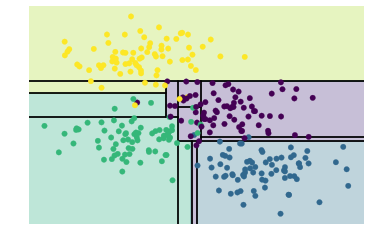

In [10]:
# helpers_05_08 is found in the online appendix
import helpers_05_08
helpers_05_08.plot_tree_interactive(X, y);

Note: as the depth increases, __we tend to get very strangely shaped classification regions.__ (Example: at depth=5 there is a tall and skinny purple region between the yellow and blue regions.)

This is less a result of the true, intrinsic data distribution, and more a result of the sampling or noise properties of the data. Our decision tree, even at only five levels deep, is over-fitting our data.

### Decision trees and over-fitting

Over-fitting is a common problem of decision trees. It is very easy to go too deep & fit details of specific data rather than distributions. Another way to see this issue is to look at models trained on different subsets of the data - see below.

![](05.08-decision-tree-overfitting.png)

The two trees can produce consistent results (corners), while in other places, the two trees give very different classifications (the regions between any two clusters).

Inconsistencies happen where the classification is less certain. Using information from __both trees__ may improve the results.

### Ensembles of Estimators: Random Forests

Bagging uses an ensemble of parallel estimators, each of which over-fits the data, and averages the results to find a better classification. An ensemble of randomized decision trees is known as a *random forest*.

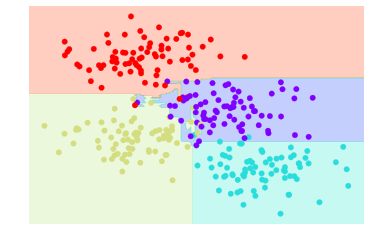

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

We randomized the data __by fitting each estimator with a random subset of 80% of the training points__.

In practice, decision trees are __more effectively randomized by injecting some stochasticity in how the splits are chosen__. This contributes all the data to the fit each time, but the results still have the desired randomness. 

An optimized ensemble of randomized decision trees is implemented in 

The ``RandomForestClassifier`` estimator, which takes care of all the randomization automatically. You simply select the number of estimators.

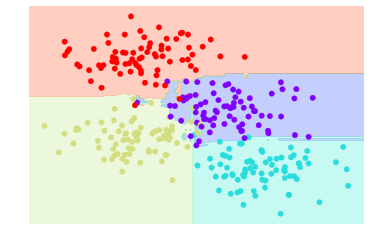

In [12]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

By averaging over 100 randomly perturbed models, we end up with an overall model that is much closer to our intuition.

### Random Forest Regression

Random forests also work with regressions (continuous variables). We'll use the ``RandomForestRegressor`` method. The following data is the combination of a fast and slow oscillation:

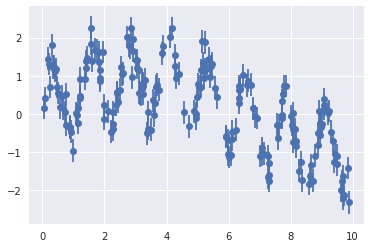

In [13]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

Find the best fit curve using the Random Forest regressor.

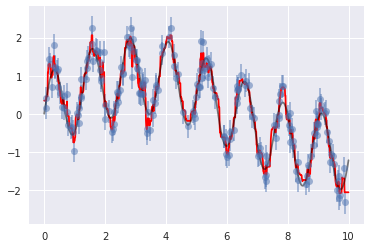

In [14]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

### Example: Random Forest for Classifying Digits

Let's reuse the digits dataset to demonstrate a random forest classifier.

In [15]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

View the first few data points:

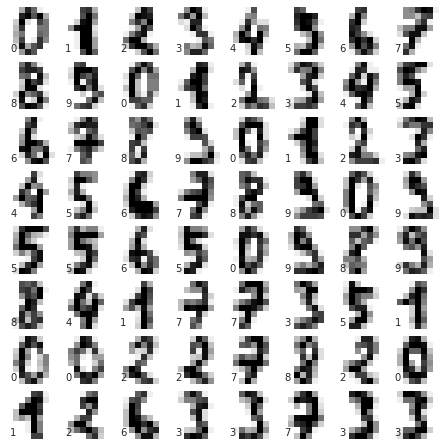

In [16]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.15, wspace=0.15)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

Classify the digits using a random forest.

In [17]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target, random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

View the classification report and confusion matrix for this classifier.

In [18]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

             precision    recall  f1-score   support

          0       1.00      0.97      0.99        38
          1       1.00      0.96      0.98        45
          2       0.95      1.00      0.98        42
          3       0.98      0.98      0.98        45
          4       0.97      1.00      0.99        37
          5       0.98      0.98      0.98        48
          6       1.00      1.00      1.00        52
          7       1.00      0.96      0.98        50
          8       0.94      0.98      0.96        46
          9       0.98      0.98      0.98        47

avg / total       0.98      0.98      0.98       450



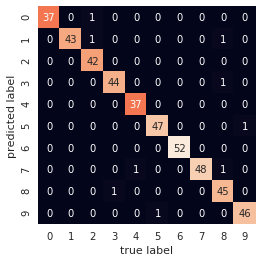

In [19]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

### Summary of Random Forests

__Advantages__:
- Training & prediction are very fast due to simplicity of the data. 
- Tasks can be parallelized (individual trees are independent entities).
- Multiple trees enable probabilistic classification: a majority vote gives an estimate of the probability (using the ``predict_proba()`` method).
- The nonparametric model is flexible & performs well on tasks that are under-fit by other estimators.

__Disadvantages__:
- Results are not easily interpretable. If you need to draw conclusions about the *meaning* of the classification model, random forests may not be the best choice.